# Fake News Detection

## 1. Data preparation

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyodbc
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [48]:
plt.style.use("ggplot")

In [6]:
SERVER_MSSQL = os.getenv("SERVER_MSSQL")
DATABASE_MSSQL = os.getenv("DATABASE_MSSQL")
UID_MSSQL = os.getenv("UID_MSSQL")
PWD_MSSQL = os.getenv("PWD_MSSQL")

conn = pyodbc.connect(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    f"SERVER={SERVER_MSSQL};"
    f"DATABASE={DATABASE_MSSQL};"
    f"UID={UID_MSSQL};"
    f"PWD={PWD_MSSQL};"
    "Encrypt=yes;"
    "TrustServerCertificate=yes;"
)

In [7]:
target_variable = "label"
categorical_features = ["author", "state", "source", "category", "has_images", "has_videos", "political_bias", "fact_check_rating", "is_satirical"]
numerical_features = ["sentiment_score", "word_count", "char_count", "readability_score", "num_shares", "num_comments", "trust_score", "source_reputation", "clickbait_score",
                      "plagiarism_score"]

In [9]:
features = [target_variable] + categorical_features + numerical_features
features_query = ", ".join(x for x in features)

In [10]:
query = f"SELECT {features_query} FROM dbo.fake_news_detection"
df = pd.read_sql(query, conn)
print("Shape", df.shape)

Shape (4000, 20)


C:\Users\Wilder\AppData\Local\Temp\ipykernel_22320\1382865238.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [11]:
df.head()

,label,author,state,source,category,has_images,has_videos,political_bias,fact_check_rating,is_satirical,sentiment_score,word_count,char_count,readability_score,num_shares,num_comments,trust_score,source_reputation,clickbait_score,plagiarism_score
0,FAKE,JANE SMITH,TENNESSEE,THE ONION,ENTERTAINMENT,False,False,CENTER,FALSE,True,-0.22,1302,5070,66.18,47305,450,76,6,0.84,53.35
1,FAKE,EMILY DAVIS,WISCONSIN,THE GUARDIAN,TECHNOLOGY,True,False,LEFT,MIXED,True,0.92,322,2722,41.10,39804,530,1,5,0.85,28.28
2,FAKE,JOHN DOE,MISSOURI,NEW YORK TIMES,SPORTS,False,True,CENTER,MIXED,False,0.25,228,5904,30.04,45860,763,57,1,0.72,0.38
3,FAKE,ALEX JOHNSON,NORTH CAROLINA,CNN,SPORTS,True,False,CENTER,TRUE,True,0.94,155,825,75.16,34222,945,18,10,0.92,32.20
4,REAL,EMILY DAVIS,CALIFORNIA,DAILY MAIL,TECHNOLOGY,True,False,RIGHT,MIXED,False,-0.01,962,1087,43.90,35934,433,95,6,0.66,77.70


### 1.1. Categorical

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
# Get transformer instance 
# sparse_output = False to return the values as vectors
# drop = first to remove first class, because the rest of classes are enough explanatory and reduce training time 
onehot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

# Training
encoded_features = onehot_encoder.fit_transform(df[categorical_features])

# Turn result into a dataframe
df_one_hot_encoder = pd.DataFrame(encoded_features, columns = onehot_encoder.get_feature_names_out())

### 1.2. Numeric

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()
ar = scaler.fit_transform(df[numerical_features])
df_numeric = pd.DataFrame(ar, columns = numerical_features)

for c in numerical_features:
    df[c] = df_numeric[c]
    
print("Shape:", df.shape)
df.head()

Shape: (4000, 20)


,label,author,state,source,category,has_images,has_videos,political_bias,fact_check_rating,is_satirical,sentiment_score,word_count,char_count,readability_score,num_shares,num_comments,trust_score,source_reputation,clickbait_score,plagiarism_score
0,FAKE,JANE SMITH,TENNESSEE,THE ONION,ENTERTAINMENT,False,False,CENTER,FALSE,True,0.390,0.858571,0.609658,0.723779,0.946058,0.450,0.76,0.555556,0.84,0.533580
1,FAKE,EMILY DAVIS,WISCONSIN,THE GUARDIAN,TECHNOLOGY,True,False,LEFT,MIXED,True,0.960,0.158571,0.296425,0.221777,0.795921,0.530,0.01,0.444444,0.85,0.282654
2,FAKE,JOHN DOE,MISSOURI,NEW YORK TIMES,SPORTS,False,True,CENTER,MIXED,False,0.625,0.091429,0.720918,0.000400,0.917135,0.763,0.57,0.000000,0.72,0.003403
3,FAKE,ALEX JOHNSON,NORTH CAROLINA,CNN,SPORTS,True,False,CENTER,TRUE,True,0.970,0.039286,0.043356,0.903523,0.684194,0.945,0.18,1.000000,0.92,0.321890
4,REAL,EMILY DAVIS,CALIFORNIA,DAILY MAIL,TECHNOLOGY,True,False,RIGHT,MIXED,False,0.495,0.615714,0.078308,0.277822,0.718460,0.433,0.95,0.555556,0.66,0.777300


### 1.3. Target variable

In [16]:
df[target_variable] = df[target_variable].map(lambda x: 1 if x == "FAKE" else 0)
df[target_variable].unique()

array([1, 0])

### 1.4. Get transformed dataset

In [32]:
df_train_encoded = pd.concat([df[numerical_features], df_one_hot_encoder, df[target_variable]], axis = 1)
print("Shape:", df_train_encoded.shape)
df_train_encoded.head()

Shape: (4000, 58)


,sentiment_score,word_count,char_count,readability_score,num_shares,num_comments,trust_score,source_reputation,clickbait_score,plagiarism_score,...,category_SPORTS,category_TECHNOLOGY,has_images_True,has_videos_True,political_bias_LEFT,political_bias_RIGHT,fact_check_rating_MIXED,fact_check_rating_TRUE,is_satirical_True,label
0,0.390,0.858571,0.609658,0.723779,0.946058,0.450,0.76,0.555556,0.84,0.533580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0.960,0.158571,0.296425,0.221777,0.795921,0.530,0.01,0.444444,0.85,0.282654,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
2,0.625,0.091429,0.720918,0.000400,0.917135,0.763,0.57,0.000000,0.72,0.003403,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,0.970,0.039286,0.043356,0.903523,0.684194,0.945,0.18,1.000000,0.92,0.321890,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1
4,0.495,0.615714,0.078308,0.277822,0.718460,0.433,0.95,0.555556,0.66,0.777300,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0


## 2. Modeling

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [33]:
y = df_train_encoded.pop(target_variable).values
x = df_train_encoded.values

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (3200, 57)
y_train shape: (3200,)
x_test shape: (800, 57)
y_test shape: (800,)


### 2.1. Create dataset

In [35]:
class TabularDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [36]:
train_dataset = TabularDataset(x_train, y_train)
test_dataset = TabularDataset(x_test, y_test)

In [37]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

### 2.2. Neural Network Model

In [38]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [57]:
input_dim = x_train.shape[1]
model = NeuralNet(input_dim)

In [58]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weights = torch.tensor(class_weights, dtype = torch.float32)

In [59]:
criterion = nn.BCELoss(weight = class_weights[1])  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [60]:
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

Epoch 1, Loss: 0.6871379429101944
Epoch 2, Loss: 0.6868086296319962
Epoch 3, Loss: 0.6868320292234421
Epoch 4, Loss: 0.6857718342542648
Epoch 5, Loss: 0.6836972242593765
Epoch 6, Loss: 0.6775186914205551
Epoch 7, Loss: 0.6679276263713837
Epoch 8, Loss: 0.6458459085226059
Epoch 9, Loss: 0.6190924063324929
Epoch 10, Loss: 0.5934881210327149
Epoch 11, Loss: 0.5470734080672264
Epoch 12, Loss: 0.5014818540215492
Epoch 13, Loss: 0.45776066452264785
Epoch 14, Loss: 0.4111605893075466
Epoch 15, Loss: 0.34521093040704726
Epoch 16, Loss: 0.31094555616378783
Epoch 17, Loss: 0.26575802445411684
Epoch 18, Loss: 0.22062536358833312
Epoch 19, Loss: 0.19733783710747957
Epoch 20, Loss: 0.1562278906814754
Epoch 21, Loss: 0.1307526227273047
Epoch 22, Loss: 0.1171068830601871
Epoch 23, Loss: 0.09797282440587879
Epoch 24, Loss: 0.09947376149706542
Epoch 25, Loss: 0.07556606626603753
Epoch 26, Loss: 0.050876875882968305
Epoch 27, Loss: 0.07422149619669653
Epoch 28, Loss: 0.049172143593896184
Epoch 29, Loss:

In [61]:
model.eval()
correct = 0
total = 0

y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted = (outputs >= 0.5).float()

        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(predicted.numpy().flatten())

# Calculate evaluation metrics
acc = accuracy_score(y_true, y_pred)
pre = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {pre:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.4650
Precision: 0.4800
Recall: 0.4964
F1 Score: 0.4880


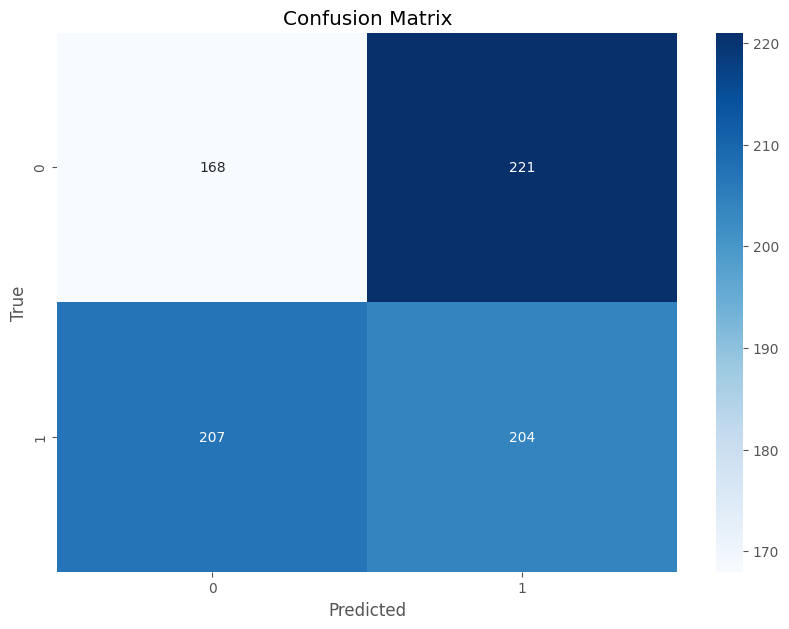

In [62]:
# Assuming y_test and y_pred are your true labels and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot=True, fmt = "d", cmap = "Blues", xticklabels = range(2), yticklabels = range(2))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()